<a href="https://colab.research.google.com/github/satoshi30/diveintocode-ml/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image segmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

このチュートリアルでは、変更されたU-Netを使用した画像セグメンテーションのタスクに焦点を当てています。

画像のセグメンテーションとは何ですか？
これまでのところ、ネットワークのタスクが入力画像にラベルまたはクラスを割り当てることである画像分類を見てきました。ただし、オブジェクトが画像のどこにあるか、そのオブジェクトの形状、どのピクセルがどのオブジェクトに属しているかなどを知りたいとします。この場合、画像をセグメント化する必要があります。つまり、画像の各ピクセルはラベルを与えられた。したがって、画像セグメンテーションのタスクは、画像のピクセル単位のマスクを出力するようにニューラルネットワークをトレーニングすることです。これは、はるかに低いレベル、つまりピクセルレベルで画像を理解するのに役立ちます。画像セグメンテーションには、医療画像、自動運転車、衛星画像など、多くの用途があります。

このチュートリアルで使用するデータセットは、Parkhi らが作成したOxford-IIIT Pet Datasetです。データセットは、画像、それらに対応するラベル、ピクセル単位のマスクで構成されています。マスクは基本的に各ピクセルのラベルです。各ピクセルには、次の3つのカテゴリのいずれかが割り当てられます。

クラス1：ペットに属するピクセル。
クラス2：ペットに隣接するピクセル。
クラス3：上記のいずれでもない/周囲のピクセル。

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-c4ac5n5c
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-c4ac5n5c
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ed49a43f918843a83449a6e148fcf4bc80d0a9eb_-cp36-none-any.whl size=137063 sha256=563c5ca327390cd3208a8289ef8c7deb16002636dc46a5f90d4ec401f6fa9989
  Stored in directory: /tmp/pip-ephem-wheel-cache-r83xz8o5/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
     |████████████████████████████████| 3.5MB 5.5MB/s 


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Oxford-IIIT Petsデータセットをダウンロードする
データセットはTensorFlowデータセットにすでに含まれています。それを行うために必要なのは、それをダウンロードすることだけです。セグメンテーションマスクはバージョン3以降に含まれています。

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteKOZQCF/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteKOZQCF/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


次のコードは、画像を反転する単純な拡張を実行します。さらに、画像は[0,1]に正規化されます。最後に、上記のように、セグメンテーションマスクのピクセルには{1、2、3}のいずれかのラベルが付けられます。便宜上、セグメンテーションマスクから1を引いて、{0、1、2}のラベルを作成します。

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

データセットには、テストとトレーニングの必要な分割がすでに含まれているため、同じ分割を引き続き使用してみましょう。

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

画像の例を見てみましょう。これは、データセットの対応するマスクです。

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

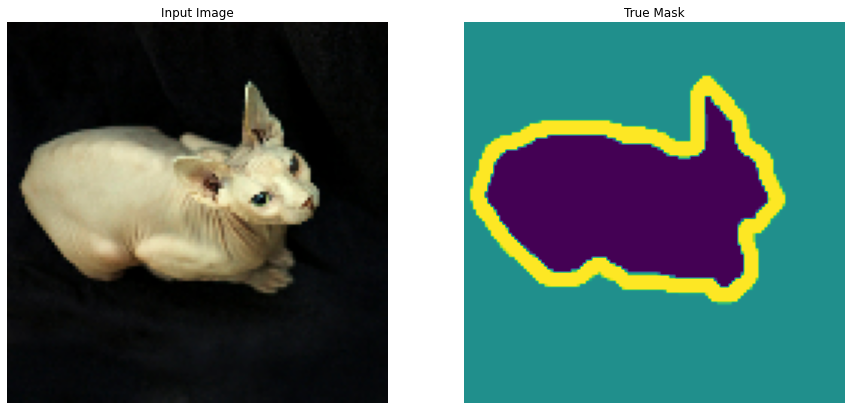

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## モデルを定義する
ここで使用されているモデルは、修正されたU-Netです。U-Netは、エンコーダー（ダウンサンプラー）とデコーダー（アップサンプラー）で構成されています。堅牢な機能を学習し、トレーニング可能なパラメーターの数を減らすために、事前トレーニング済みモデルをエンコーダーとして使用できます。したがって、このタスクのエンコーダーは、中間出力が使用される事前トレーニング済みのMobileNetV2モデルであり、デコーダーは、[Pix2pixチュートリアル](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py)の TensorFlowの例ですでに実装されているアップサンプルブロックです。

3つのチャネルを出力する理由は、各ピクセルに3つの可能なラベルがあるためです。これは、各ピクセルが3つのクラスに分類される複数の分類と考えてください。

In [ ]:
OUTPUT_CHANNELS = 3

前述のように、エンコーダーは事前にトレーニングされたMobileNetV2モデルで、[tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications)で使用できるように準備されています。エンコーダーは、モデルの中間層からの特定の出力で構成されます。エンコーダーはトレーニングプロセス中にトレーニングされないことに注意してください。

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


デコーダー/アップサンプラーは、TensorFlowの例に実装された一連のアップサンプルブロックです。

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## モデルをトレーニングする
あとは、モデルをコンパイルしてトレーニングするだけです。ここで使用されている損失はlosses.SparseCategoricalCrossentropy(from_logits=True)です。この損失関数を使用する理由は、マルチクラス予測と同様に、ネットワークが各ピクセルにラベルを割り当てようとしているためです。真のセグメンテーションマスクでは、各ピクセルに{0,1,2}があります。ここのネットワークは3つのチャネルを出力しています。基本的に、各チャネルはクラスを予測することを学習しようとしているため、losses.SparseCategoricalCrossentropy(from_logits=True)そのようなシナリオで推奨される損失です。ネットワークの出力を使用して、ピクセルに割り当てられたラベルは、最高の値を持つチャネルです。これがcreate_mask関数が行っていることです。

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

結果のモデルアーキテクチャをざっと見てみましょう。

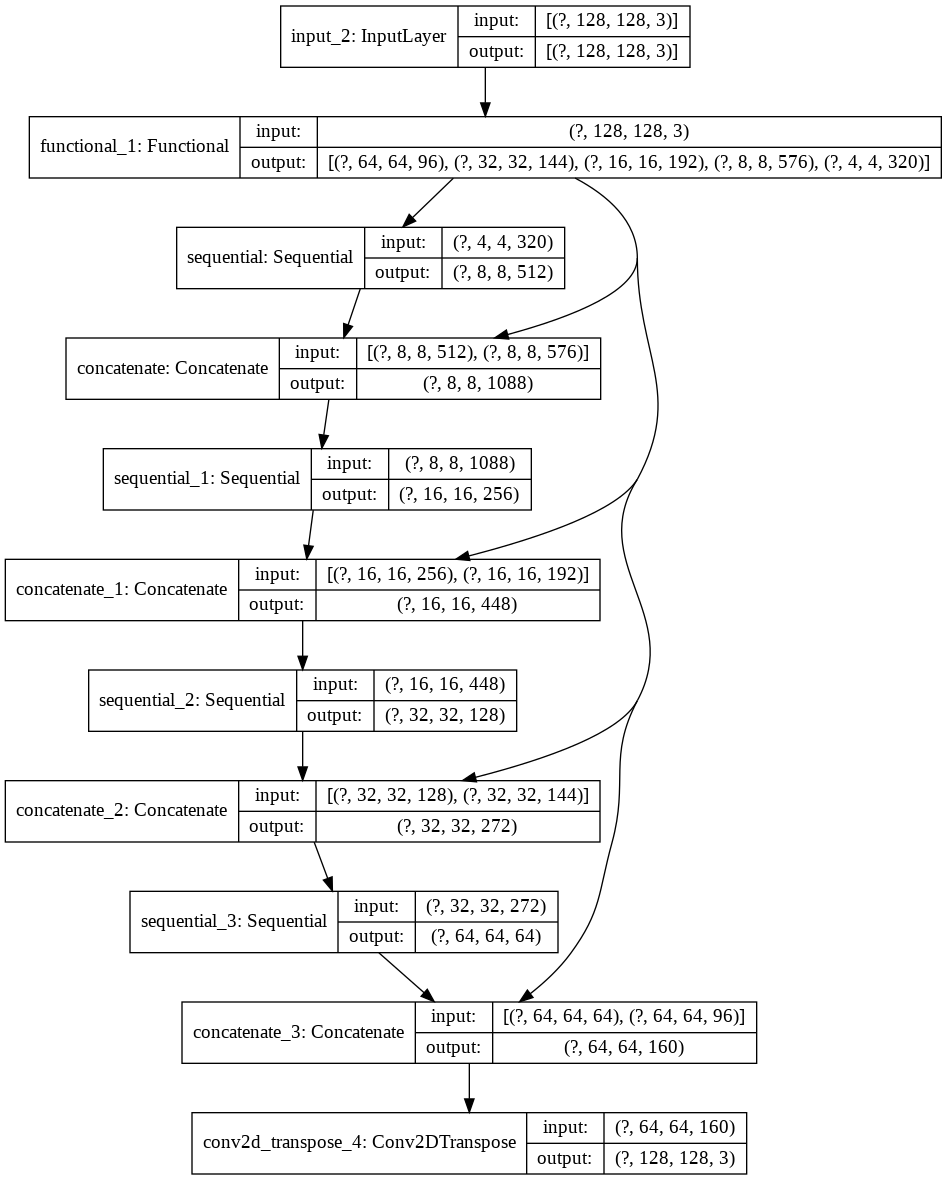

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

モデルを試して、トレーニングの前にそれが予測するものを見てみましょう。

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

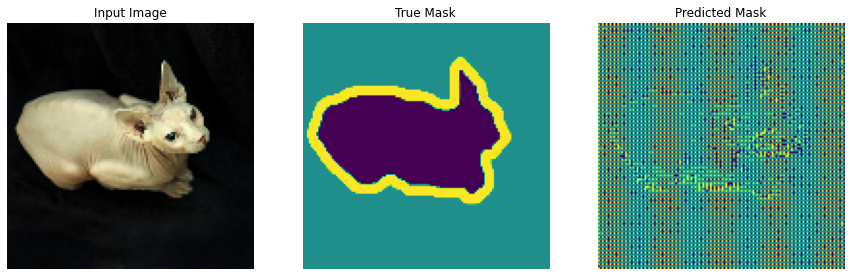

In [ ]:
show_predictions()

トレーニング中にモデルがどのように改善されるかを見てみましょう。このタスクを実行するために、以下にコールバック関数が定義されています。

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

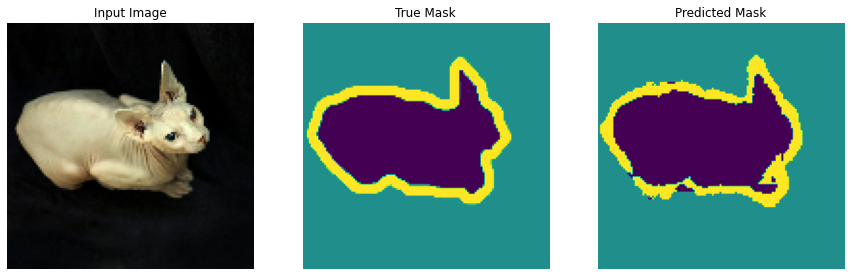


Sample Prediction after epoch 20

57/57 [==============================] - 8s 149ms/step - loss: 0.1315 - accuracy: 0.9398 - val_loss: 0.3225 - val_accuracy: 0.8904


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

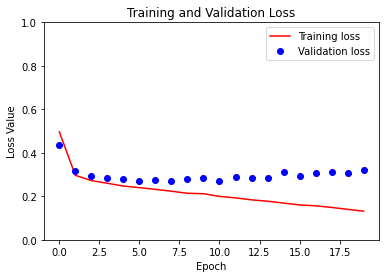

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 予測を行います

予測してみましょう。時間を節約するために、エポックの数は少なく保たれましたが、より正確な結果を得るために、これをより高く設定することができます。

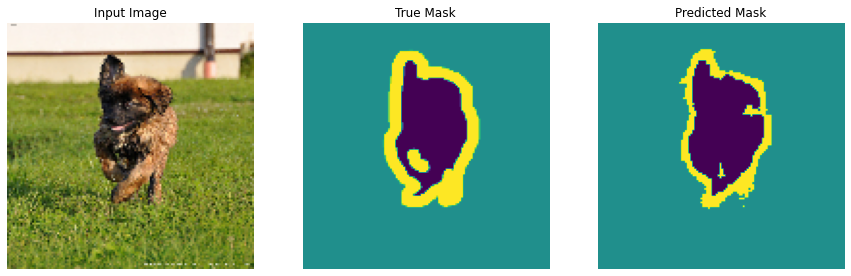

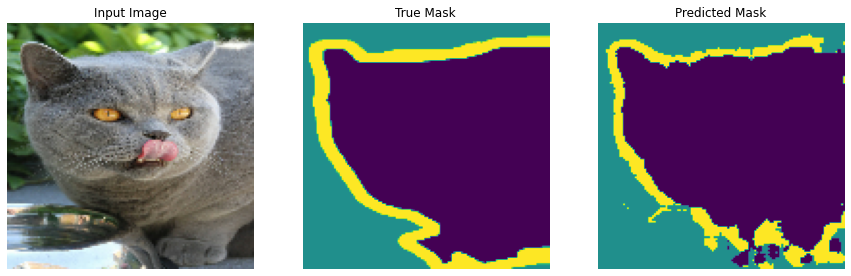

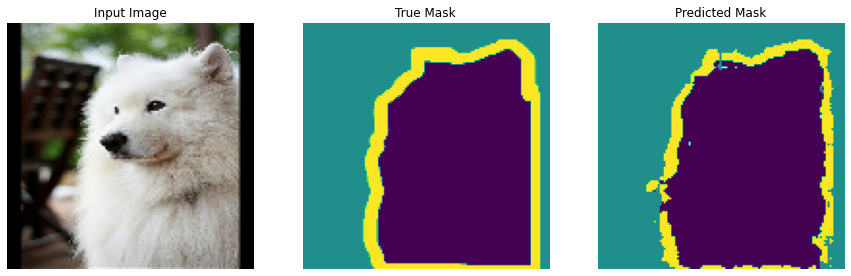

In [ ]:
show_predictions(test_dataset, 3)

## 次のステップ

画像のセグメンテーションとは何か、そしてそれがどのように機能するかを理解したので、このチュートリアルをさまざまな中間層出力またはさまざまな事前トレーニング済みモデルで試すことができます。Kaggleでホストされている[Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview)画像マスキングチャレンジを試すことによって、自分自身に挑戦することもできます。

また、独自のデータで再トレーニングできる別のモデルの[Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection)を確認することもできます。